<a href="https://colab.research.google.com/github/ashercurtis/MPAcc-Advanced-NLP/blob/master/edgarExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Automation of 10-K Sentiment example using Natural Language Processing (NLP)**

This code is part of the instruction in the MPAcc program at the University of Washington. If you'd like to find out more about the program please visit: https://foster.uw.edu/academics/degree-programs/master-of-professional-accounting/curriculum/


Overview: <br>
What we will do with this code is complete a complex task, that is well suited to both the use of NLP and automation. Our objective is to graph the tone or sentiment of the MD&A for each of the 10-Ks over the past seven years (although we could easily do a longer period). 

The code executes a number of differnet steps to achieve this task:

1.   Download the 10-Ks from the SEC EDGAR website. 
2.   ETL / read and clean the text from the 10-Ks.
3.   Identify the beginning and end of the MD&A (which is not a set length).
4.   Read the filings identifying the poitive and negative words.
5.   Combine the information on positive and negative words to measure tone.
6.   Display this the tone/sentiment visually on an annual basis.

To undertake  process like this manually would be time prohibitive, and is highly subject to human error (forgetting which words should be coded as positive and negative consistently for example, or missing a word). This is also a developing area, where the NLP used in this example could be extended by using machine learning to encode negative and positive phrases within context (for example, the approach below will not detect sarcasm, but will instead assume the meaning is literal). An important part of understanding the role of technology, is understanding the risks, and the risk of NLP as it appears below, is that it may not detect sarcasm or informal language. For example, a code like this probably would not perform well for the analysis of twitter posts. If you would like to see how we used machine learning to classify StockTwits social media posts, see: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3173289

I modified the original code by my colleague Ties de Kok at the University of Washington to adapt this to the colab environment. In the MPAcc at the University of Washington we use Google Colabs to learn about Python. The original code written by Ties for researchers can be found here:
https://github.com/TiesdeKok/limperg_python


In [74]:
## Upload the csv with Tesla (or an alternative firm) EDGAR filing URLS (note that the code will always call the input data "Tesla" as that was our default company)
from google.colab import files
uploaded = files.upload()

In [47]:
## Upload the sentiment dictionary (note you only have to do this once if you are uploading a different firm for analysis)
from google.colab import files
uploaded = files.upload()

Saving LoughranMcDonald_MasterDictionary_2014.xlsx to LoughranMcDonald_MasterDictionary_2014.xlsx


In [77]:
## Standard
import os, re, sys, time

## Data handling
import pandas as pd
import numpy as np

## "Web scraping" and HTML
import requests
import lxml.html

## Convenience functions
from os.path import join
#depreciated version is commented out
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

##Text cleansing tool has to be installed before imported
!pip install unidecode
import unidecode

## NLP (Spacy)
import en_core_web_sm
nlp = en_core_web_sm.load()

## code starts here
## read the csv file with the Tesla 10-K filings
Tesla_10K_df = pd.read_csv('Tesla10Ks.csv')

## Append the URL to the accession number
edgar_url = "https://www.sec.gov/Archives/"
Tesla_10K_df['download_url'] = Tesla_10K_df.FName.apply(lambda file_url: edgar_url + file_url)

## This function will download all of the files (or return an error message)
def download_file(url, max_tries=4, sleep_time = 1):
    failed_attempts = 0
    while True: 
        res = requests.get(url)
        
        if res.status_code == 200:
            return True, res.text
        else:
            if failed_attempts < max_tries:
                failed_attempts += 1
                time.sleep(sleep_time)
            else:
                return False, 'Could not download'

## Call the function to download the files
filing_dict = {}
for url in tqdm(Tesla_10K_df.download_url):
    res = download_file(url)
    if res[0] == True:
        filing_dict[url] = res[1]

tesla_10k_dict = {}
status_dict = {}
for index, row in tqdm(Tesla_10K_df.iterrows(), total=len(Tesla_10K_df.index)):
    download_res = download_file(row['download_url'])
    
    status_dict[index] = download_res[0]
    
    if download_res[0]:
        tesla_10k_dict[row['FName']] = download_res[1]

## add a variable to track the download success/failure
Tesla_10K_df['download_status'] = pd.Series(status_dict)

test_doc = tesla_10k_dict['edgar/data/1318605/0001564590-16-013195.txt']
with open('test_doc.txt', 'w') as f:
    f.write(test_doc)
## use REGEX to identify what is in the filing
pattern_dict = {
    'documents' : re.compile(r"<document>(.*?)</document>", re.IGNORECASE | re.DOTALL),
    'metadata' : {
        'type' : re.compile(r"<type>(.*?)\n", re.IGNORECASE | re.DOTALL),
        'sequence' : re.compile(r"<sequence>(.*?)\n", re.IGNORECASE | re.DOTALL),
        'filename' : re.compile(r"<filename>(.*?)\n", re.IGNORECASE | re.DOTALL),
        'description' : re.compile(r"<description>(.*?)\n", re.IGNORECASE | re.DOTALL)
    },
    'text' : re.compile(r"<text>(.*?)</text>", re.IGNORECASE | re.DOTALL)
}
pattern_dict['metadata']['filename'].findall(test_doc)

docs_split = pattern_dict['documents'].findall(test_doc)

## This function extracts the meta data from the filing to identify the filing type
def extract_metadata(doc, pattern_dict=pattern_dict):
    data_dict = {}
    
    data_dict['metadata'] = {}
    for key, pattern in pattern_dict['metadata'].items():
        matches = pattern.findall(doc)
        if matches:
            data_dict['metadata'][key] = matches[0]
        else:
            data_dict['metadata'][key] = np.nan
            
    text_match = pattern_dict['text'].findall(doc)
    if text_match:
        data_dict['text'] = text_match[0]
    else:
        data_dict['text'] = np.nan
        
    return data_dict

## this calls the metadata function to identify all of the components
data_10k_dict = {}
for filename, data in tqdm(tesla_10k_dict.items()):
    docs_split = pattern_dict['documents'].findall(data)
        
    for doc in docs_split:
        doc_data = extract_metadata(doc)
        
        ## Only keep 10-K document
        if doc_data['metadata']['type'] == '10-K':
            data_10k_dict[filename] = doc_data['text']
            break

html_10k_dict = {}
text_10k_dict = {}
for filename, raw_text in tqdm(data_10k_dict.items()):
    html = lxml.html.fromstring(raw_text)
    html_10k_dict[filename] = html
    text_10k_dict[filename] = html.text_content()

## The following cleans the text file removing some of the characters like new line \n, table of contents and page numbers 
cleantext_10k_dict = {}
for filename, text in tqdm(text_10k_dict.items()):
    ## Fix encoding (removes noisy ascii codes if they are in the filing and turns them into text eg the smiley emoji)
    clean_text = unidecode.unidecode(text)
    
    ## Replace newline characters with space
    clean_text = re.sub('\s', ' ', clean_text)
    
    ## Remove duplicate whitespaces
    clean_text = ' '.join([word for word in clean_text.split(' ') if word != ''])
    
    ## Replace "Page number + Table of Contents footer"
    clean_text = re.sub(' \d+ Table of Contents ', ' ', clean_text)
    
    cleantext_10k_dict[filename] = clean_text

#############################################################################################
## This is the most complex part of this code, as part of the ETL process. 
## We need to be able to identify the beginning and end of the MD&A. 
## This is easy to do as a human, but requires a few logic checks for the computer.
#############################################################################################

def extract_MDA_from_10K(text, section_number_range = 10, keyword_range = 200, 
                         reference_range = 10, title_range = 100, min_length = 1000):
    """Extract the MD&A part out of a 10-K filing. """
    
    ## Split the document based on the word "item"
    parts = re.split('item|Item|ITEM', text)
    
    # ------------------------------------------
    # Step 1: try to find where the MD&A begins
    # ------------------------------------------

    ## Loop over each part and check whether it starts with 7 that is not followed by an "a"
    valid_start_parts = []
    for i, text in enumerate(parts):
        if '7' in text.strip()[:section_number_range] and not '7a' in text.strip().lower()[:section_number_range]:
            valid_start_parts.append(i)
    
    # ----------------------------------------
    # Step 2: try to find where the MD&A ends
    # ----------------------------------------

    results = []
    reference = 0

    ## Loop over all elements that start with 7 (excluding those starting with 7a)
    for i in valid_start_parts:
        mda_text = parts[i]
        endPoint = i+1

        isValid = 0
        reference = 0

        ## Loop over the elements that follow the current element and check whether it matches item 7a
        while endPoint < len(parts):
            end_part_text = parts[endPoint]
            ## Check if potential candidate for ending part
            if '7a' in end_part_text.strip().lower()[:section_number_range]:
                
                ## Check for keywords (quan and qual) that indicate start section 7a (and not just 7a mentioned in the text)
                if end_part_text[:keyword_range].lower().find('quan') >= 0 and end_part_text[:keyword_range].lower().find('qual') >= 0:
                    
                    ## Final check to make sure it is not a reference, if not then consider valid and break loop
                    if mda_text[-reference_range:].lower().find(' see ') <= 0 and mda_text[-reference_range:].lower().find(' in ') <= 0:
                        isValid = 1
                        break
            
            ## If not the end then add the part of the text but keep searching by going to the next one
            mda_text = ' '.join((mda_text, parts[endPoint]))
            endPoint += 1
            
        # ----------------------------------------
        # Step 3: double check it is a valid text
        # ----------------------------------------
        
        ## Short hits are either invalid or imply incorporated by reference
        if (len(mda_text) < min_length):
            if mda_text.lower().find('incorporated') and mda_text.lower().find('reference'):
                reference = 1
            else:
                isValid = 0

        ## Check whether it contains the title, otherwise consider it an invalid hit
        if mda_text[:title_range].lower().find('discussion') < 0 and mda_text[:title_range].lower().find('analysis') < 0:
            isValid = 0

        ## Append valid hits that do not indicate incorporated by reference
        if isValid:
            if not reference:
                results.append(mda_text)

    ## Return the shortest possible valid mda_text:
    if len(results) > 0:
        return {'status' : 'Good', 
                'mda_text' : sorted(results, key = len)[0]}
    else:
        if reference:
            return {'status' : 'Reference', 
                    'mda_text' : None}
        else:
            return {'status' : 'Not found', 
                    'mda_text' : None}

## call the function and hopefully identify the MD&A for all of the filings
mda_text_dict = {}
mda_status_list = []
for filename, text in tqdm(cleantext_10k_dict.items()):
    mda_result = extract_MDA_from_10K(text)
    
    mda_status_list.append([filename, mda_result['status']])
    
    if mda_result['status'] == 'Good':
        mda_text_dict[filename] = mda_result['mda_text']

## Tokenize the MD&A text data to prepare it for sentiment analysis 
spacy_mda_dict = {}
for filename, mda_text in tqdm(mda_text_dict.items()):
    spacy_mda_dict[filename] = nlp(mda_text)

mda_sen_and_token_dict = {}
for filename, spacy_obj in tqdm(spacy_mda_dict.items()):
    sentences = []
    for sentence in spacy_obj.sents:
        sentences.append([token.text.lower() for token in sentence])
    mda_sen_and_token_dict[filename] = sentences

## Read the dictionary to memory to classify words as positive negative or neutral
lm_df = pd.read_excel('LoughranMcDonald_MasterDictionary_2014.xlsx')
negative_words = [str(x).lower() for x in lm_df[lm_df.Negative != 0].Word.values]
positive_words = [str(x).lower() for x in lm_df[lm_df.Positive != 0].Word.values]

## Classify the words according to the dictionary
tone_data = []
for filename, sentences in tqdm(mda_sen_and_token_dict.items()):
    pos_words, neg_words, num_words = 0, 0, 0
    
    for sentence in sentences:
        num_words += len(sentence)
        
        for neg_word in negative_words:
            neg_words += sentence.count(neg_word)
            
        for pos_word in positive_words:
            pos_words += sentence.count(pos_word)
            
    tone_data.append([filename, pos_words, neg_words, num_words])

## Save as a data file
mda_tone_df = pd.DataFrame(tone_data, columns = ['filename', 'pos_words', 'neg_words', 'num_words'])

## Calculate the tone score per filing
mda_tone_df['tone_score'] = (mda_tone_df['pos_words'] - mda_tone_df['neg_words']) / mda_tone_df['num_words']

## Calculate tone at the sentence level instead of the word level
tone_data_sen = []
for filename, sentences in tqdm(mda_sen_and_token_dict.items()):
    pos_words, neg_words, num_words = 0, 0, 0
    
    for i, sentence in enumerate(sentences):
        pos_words, neg_words, num_words = 0, 0, len(sentence)
        
        for neg_word in negative_words:
            neg_words += sentence.count(neg_word)
            
        for pos_word in positive_words:
            pos_words += sentence.count(pos_word)
            
        tone_data_sen.append([filename, i, pos_words, neg_words, num_words])

mda_sen_tone_df = pd.DataFrame(tone_data_sen, columns = ['filename', 'sentence', 'pos_words', 'neg_words', 'num_words'])
mda_sen_tone_df['tone_score'] = (mda_sen_tone_df['pos_words'] - mda_sen_tone_df['neg_words']) / mda_sen_tone_df['num_words']

## Add labels and output to a dataframe
def classify_sentence(tone_score):
    if tone_score > 0:
        return 'pos'
    elif tone_score < 0:
        return 'neg'
    else:
        return 'neut'

mda_sen_tone_df['tone'] = mda_sen_tone_df.tone_score.apply(classify_sentence)
mda_tone_counts = pd.pivot_table(mda_sen_tone_df, columns='tone', index='filename', aggfunc='count')['tone_score'].reset_index()
mda_tone_counts['sen_tone_score'] = (mda_tone_counts['pos'] - mda_tone_counts['neg']) / mda_tone_counts['neut']


## merge /join the dataframes together
mda_scores_df = pd.merge(mda_tone_df[['filename', 'tone_score']], mda_tone_counts[['filename', 'sen_tone_score']], how='left', on='filename')

mda_scores_df = pd.merge(mda_scores_df, Tesla_10K_df[['FName', 'FDATE']].rename(columns={'FName' : 'filename'}), how='left', on='filename')

##scale the scores so that a sentence and word derived approach look similar assume 30 words per sentence
mda_scores_df['tone_score_scaled'] = mda_scores_df['tone_score'] * 30

## calculate a changes in tone/sentiment measure to graph
mda_scores_df['sen_tone_score_lagged'] = mda_scores_df.sen_tone_score.shift(1)
mda_scores_df['sen_tone_score_delta'] = mda_scores_df['sen_tone_score'] - mda_scores_df['sen_tone_score_lagged']

**The code above prepares the data for visualization, in this section we will visualize the data using python's visualization functions**
If you have changed the input company, then you will want to update the title of the graphs from 'Yearly tone score for Tesla' to your company's name.

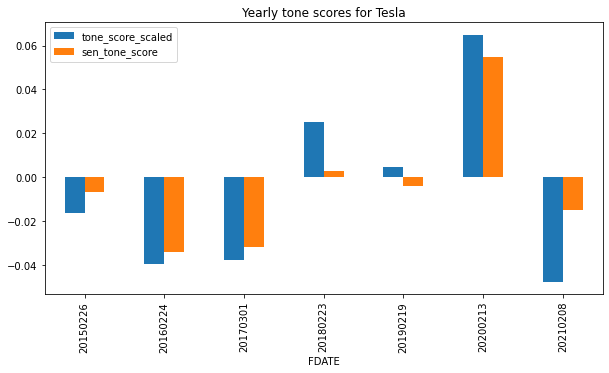

In [78]:
mda_scores_df.set_index('FDATE')[['tone_score_scaled', 'sen_tone_score']].plot(kind='bar', 
                                                                              figsize=(10,5),
                                                                              title='Yearly tone scores for Tesla')

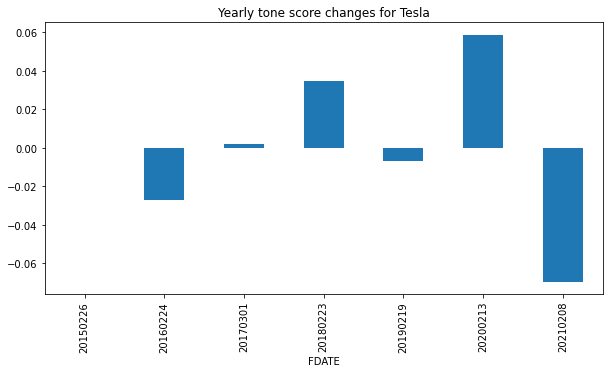

In [79]:
mda_scores_df.set_index('FDATE')['sen_tone_score_delta'].plot(kind='bar', 
                                                             figsize=(10,5),
                                                             title='Yearly tone score changes for Tesla')

**Check the data** <br>
Below are ways to interact with the data to see how it is cleaned up in the process if you change the company, you need to choose a different example filing URL. The code below will get you the first URL which you can update some of the commands below with (i.e., the ones that use 'https://www.sec.gov/Archives/edgar/data/1318605/0001564590-15-001031.txt' you can replace with the output of below.

In [81]:
Tesla_10K_df.iloc[0]['download_url']

'https://www.sec.gov/Archives/edgar/data/1318605/0001564590-15-001031.txt'

In [ ]:
#Tesla_10K_df.head(2)
#print(tesla_10k_dict['edgar/data/1318605/0001564590-15-001031.txt'][:1000])
#print(len(docs_split))
#test = extract_metadata(docs_split[0])
#test.keys()
#test['metadata']
#len(data_10k_dict)
#print(data_10k_dict['edgar/data/1318605/0001564590-16-013195.txt'][:1000])
#text_10k_dict['edgar/data/1318605/0001564590-16-013195.txt'][20000:21000]
#cleantext_10k_dict['edgar/data/1318605/0001564590-16-013195.txt'][19000:21000]
#pd.DataFrame(mda_status_list, columns=['filename', 'status'])
#mda_text_dict['edgar/data/1318605/0001564590-16-013195.txt'][:3000]
#mda_text_dict['edgar/data/1318605/0001564590-16-013195.txt'][-1000:]
#mda_sen_and_token_dict['edgar/data/1318605/0001564590-16-013195.txt'][2]
#mda_tone_df.head()
#mda_tone_df
#mda_sen_tone_df.head()
#mda_sen_tone_df.head()
#mda_sen_tone_df.sample(10)
#mda_tone_counts
#mda_scores_df.head(3)
#mda_scores_df